# Initial Setup

In [1]:
import pandas as pd
import os
import numpy as np
import datetime
from plotnine import *
import matplotlib.pyplot as plt
from model_diagnostics import model_diagnostics, skf_preds, model_diagnostics_skf, summarise_continuous_feature

#pd.set_option("display.max_rows", 20)

In [2]:
filename = os.getcwd() + "/train.csv"
data = pd.read_csv(filename)

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Extract deck feature, do some EDA

In [4]:
data['Deck'] = data['Cabin'].str[0]
#data.loc[data['Cabin'].isnull(), 'Deck'] = 'M'
data['Deck'] = data['Deck'].fillna('M')
data['Cabin_no'] = data['Cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int)

In [5]:
survival_deck = (
    data
    .groupby('Deck')
    .agg(n = ('SibSp', 'count'),
         pct_survived = ('Survived', 'mean'))
    .reset_index()
)

survival_deck

,Deck,n,pct_survived
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,M,687,0.299854
8,T,1,0.000000


In [6]:
#df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
data['Deck'] = data['Deck'].replace(['A', 'T'], 'A')
data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')
data['Deck'].value_counts()

M     687
C      59
B      47
D      33
E      32
FG     17
A      16
Name: Deck, dtype: int64

In [7]:
# Different encoding for deck
# data['Deck'] = data['Deck'].replace(['D', 'E'], 'DE')
# data['Deck'] = data['Deck'].replace(['A', 'B', 'C'], 'ABC')
# data['Deck'] = data['Deck'].replace(['F', 'G'], 'FG')

# data['Deck'].value_counts()

In [8]:
survival_cabno = (
    data[data['Cabin_no'] > 0]
    .assign(cabno_quantile = lambda x: pd.qcut(x['Cabin_no'], 10))
    .groupby('cabno_quantile')
    .agg(n = ('Ticket', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

survival_cabno

,cabno_quantile,n,avg_survival
0,"(1.999, 7.0]",21,0.666667
1,"(7.0, 19.8]",19,0.789474
2,"(19.8, 25.0]",21,0.714286
3,"(25.0, 33.0]",20,0.650000
4,"(33.0, 43.0]",19,0.736842
5,"(43.0, 51.0]",21,0.619048
6,"(51.0, 68.3]",19,0.631579
7,"(68.3, 85.2]",20,0.600000
8,"(85.2, 101.0]",21,0.714286
9,"(101.0, 148.0]",19,0.578947


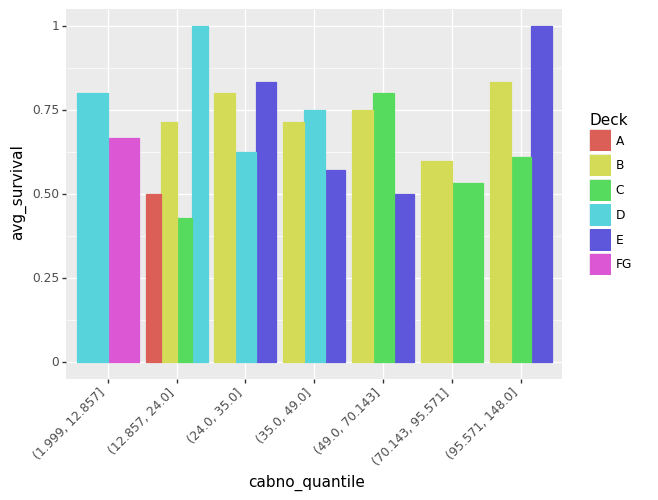

<ggplot: (8775410609399)>

In [9]:
survival_cabno_deck = (
    data[data['Cabin_no'] > 0]
    .assign(cabno_quantile = lambda x: pd.qcut(x['Cabin_no'], 7 ))
    .groupby(['cabno_quantile', 'Deck'])
    .agg(n = ('Ticket', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

(
    ggplot(survival_cabno_deck[survival_cabno_deck.n > 4])
    + aes(x = 'cabno_quantile', y = 'avg_survival', color = 'Deck', fill = 'Deck')
    + geom_bar(stat = 'identity', position = 'dodge')
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)

# Train a model including deck and cabin number

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['SibSp', 'Parch', 'Cabin_no', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2]),
                    ('disc_cabno', StandardScaler(), [-3])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss')

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_disc),
    ('clf', xgb_model),
])

cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

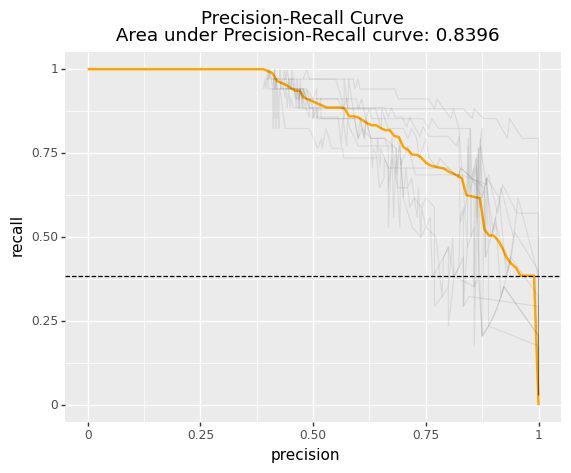

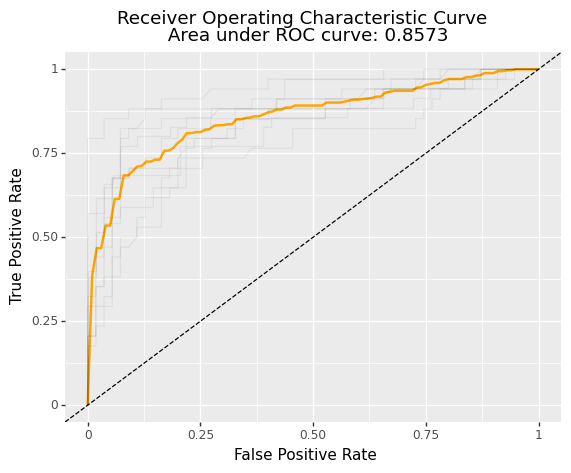

[<ggplot: (8775346042356)>, <ggplot: (8775346059885)>]

In [11]:
plots_list

# Extract title feature

In [12]:
data['Title'] = data['Name'].str.split(",", expand = True)[1].str.split('.', expand = True)[0].str.strip()

In [13]:
data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [14]:
survival_title = (
    data
    .groupby('Title')
    .agg(n = ('Name', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

survival_title

,Title,n,avg_survival
0,Capt,1,0.000000
1,Col,2,0.500000
2,Don,1,0.000000
3,Dr,7,0.428571
4,Jonkheer,1,0.000000
5,Lady,1,1.000000
6,Major,2,0.500000
7,Master,40,0.575000
8,Miss,182,0.697802
9,Mlle,2,1.000000


In [15]:
data.query('Name.str.contains("Mme")', engine = "python")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Cabin_no,Title
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3,B35,C,B,35,Mme


In [16]:
data['Title'] = data['Title'].replace(['Ms'], 'Miss')

noble_list = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
#noble_list = ['Mlle', 'the Countess', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer']
#military_clergy_list = ['Rev', 'Major', 'Col', 'Capt']

data['Title'] = data['Title'].replace(noble_list, 'Noble')
#data['Title'] = data['Title'].replace(military_clergy_list, 'Military_Clergy')
#data['Title'] = data['Title'].replace('Dr', 'Mr')

data['Title'].value_counts()

Mr        517
Miss      183
Mrs       125
Master     40
Noble      26
Name: Title, dtype: int64

In [17]:
data['Married'] = 0
data.loc[data['Title'] == 'Mrs', 'Married'] = 1

In [18]:
survival_title = (
    data
    .groupby('Title')
    .agg(n = ('Name', 'count'),
         avg_survival = ('Survived', 'mean'))
    .reset_index()
)

survival_title

,Title,n,avg_survival
0,Master,40,0.575000
1,Miss,183,0.699454
2,Mr,517,0.156673
3,Mrs,125,0.792000
4,Noble,26,0.423077


# Train a model using Title and Married features

In [19]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
import xgboost as xgb

target = 'Survived'
numeric_cols = ['SibSp', 'Parch', 'Cabin_no', 'Fare', 'Age']
categorical_cols = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20230118)


ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols), #this line adds dummies for class (3 values), sex (2 values) and embarked (4 values)
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), [-1]),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), [-2]),
                    ('disc_cabno', StandardScaler(), [-3])],
    remainder = 'passthrough'
)

ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), [-1, -2])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss')

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('imputer', IterativeImputer()),
    ('discretize', ct_disc),
    ('clf', xgb_model),
])

cv_results = cross_validate(pipe, X, y, cv = skf, scoring = 'accuracy', return_estimator = True)
preds_list, preds_binary_list, y_list = skf_preds(skf = skf, X = X, y = y, estimators = cv_results['estimator'])

df_scores, df_scores_agg, cm_display, plots_list = model_diagnostics_skf(preds_list, preds_binary_list, y_list)

In [20]:
df_scores_agg

accuracy             0.821511
average_precision    0.842128
f1_score             0.756889
auc                  0.862321
dtype: float64

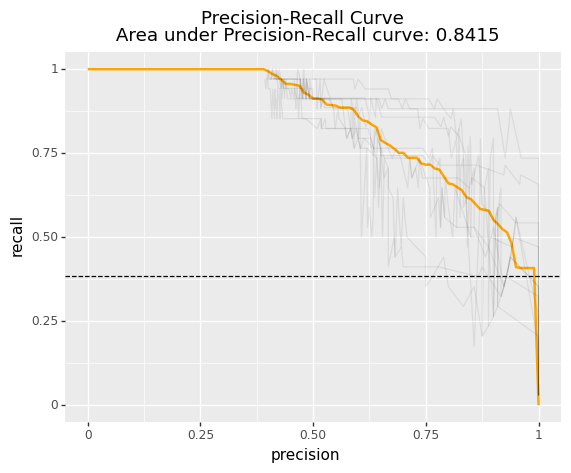

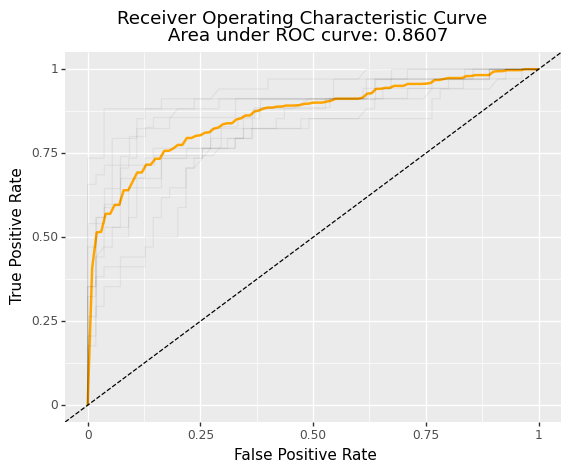

[<ggplot: (8775346124535)>, <ggplot: (8775346249725)>]

In [21]:
plots_list

# Look at Family Size Varible combining Parch and Sibsp

mean_outcome_by_quantile
            quantile    n  avg_outcome
0     (-0.001, 7.55]   92         0.14
1      (7.55, 7.854]   87         0.30
2      (7.854, 8.05]  106         0.18
3       (8.05, 10.5]   78         0.23
4     (10.5, 14.454]   84         0.43
5   (14.454, 21.679]   88         0.42
6     (21.679, 27.0]   89         0.52
7     (27.0, 39.688]   91         0.37
8   (39.688, 77.958]   89         0.53
9  (77.958, 512.329]   87         0.76
outcome_count_by_quantile
             quantile Survived   n
0      (-0.001, 7.55]        0  79
1      (-0.001, 7.55]        1  13
2       (7.55, 7.854]        0  61
3       (7.55, 7.854]        1  26
4       (7.854, 8.05]        0  87
5       (7.854, 8.05]        1  19
6        (8.05, 10.5]        0  60
7        (8.05, 10.5]        1  18
8      (10.5, 14.454]        0  48
9      (10.5, 14.454]        1  36
10   (14.454, 21.679]        0  51
11   (14.454, 21.679]        1  37
12     (21.679, 27.0]        0  43
13     (21.679, 27.0]        1

/Users/sid_basu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 107'. Pick better value with 'binwidth'.


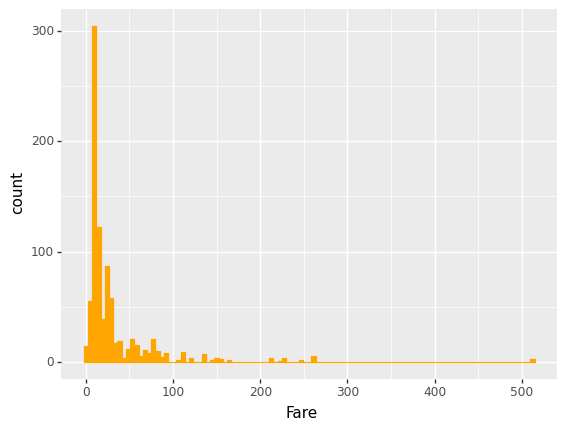


plot_mean_outcome_by_quantile


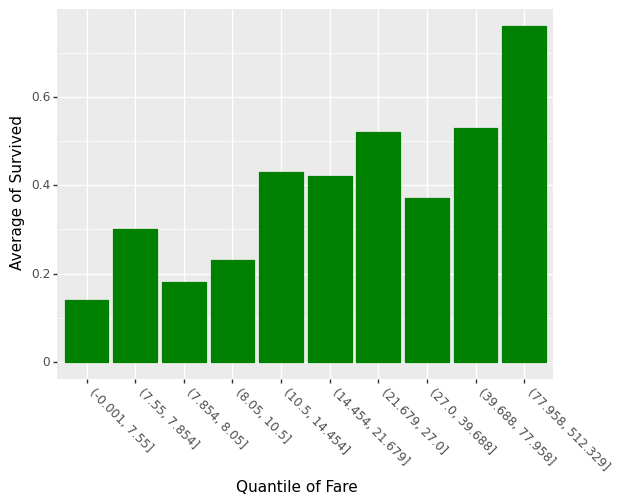


plot_outcome_counts


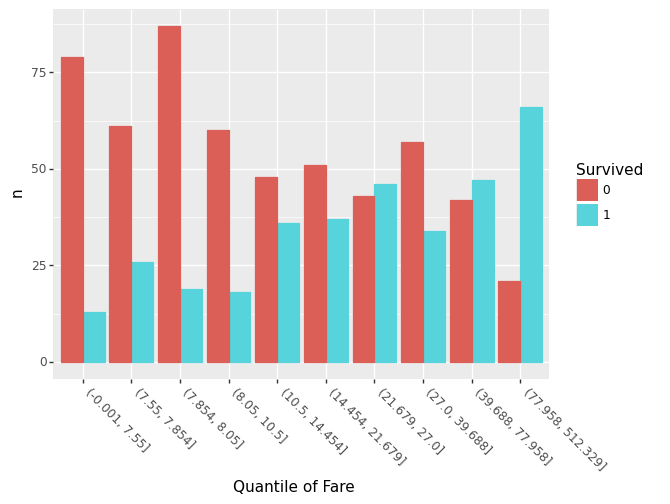

In [22]:
eda_fare = summarise_continuous_feature(df_input = data, column = 'Fare', outcome = 'Survived', n_quantiles = 10)

for (key, value) in eda_fare.items():
    print(key)
    print(value)